## Assignment 1

⚠️ **Important! Submission Requirements**

1. **Do NOT clear notebook logs or outputs.**  
   Every output cell must remain visible (e.g., print logs, progress logs, summary messages).

2. **The notebook must be *self-contained*.**  
   - You should be able to run it **from top to bottom once** without any manual steps.  
   - No need for any external scripts, config files, or multiple runs.
   - Creating multiple cells/blocks is OK.

3. **Single `.ipynb` implementation.**  
   Do not create separate Python files or folders other than the generated image output directory.

4. **Clean, readable, and well-commented code.**

5. **Submission file name format:**  
   → `studentID_name.zip`  
   (Example: `2025000000_jungbeomlee.zip`)
   - This file should contain `best.pth`, and `COSE-474-02-Assignment_1.ipynb`. DO NOT include `mnist_images` folder.
---


## Python familiarization
**🎯 Goal**

Warm up with Python and the PyTorch data ecosystem by:

1. Loading the **MNIST** dataset (train & test).  
2. Randomly splitting 10% of the training set into a validation set.  
3. Exporting the images to a folder structure on disk in the format `<split>/<class>/<zero_padded>.jpg`, e.g., `train/0/00000.jpg`, `val/1/00000.jpg`, `test/3/00000.jpg`.


**What you’ll practice**

1. Using `torchvision.datasets.MNIST` to download & access data  
2. Basic Python file I/O with `pathlib` / `os`  
3. Converting tensors/PIL images and saving to disk with `PIL`  
4. Performing a **manual dataset split** (train → train/val)  
5. Implementing **progress tracking and sanity checks**

**Dataset**

- MNIST consists of:
  - **60,000 training** images  
  - **10,000 test** images  
- Each image: 28×28 pixels, grayscale, labeled **0–9**.

**Your task**

1. **Download** both MNIST `train` and `test` datasets using `torchvision.datasets.MNIST`.  

2. **Split** the training dataset:
   - Randomly take **10% of the train samples** for **validation**.  
   - Do not use automatic random split libraries (e.g., `torch.utils.data.random_split()`). Try to manually implement the random splitting codes.
3. **Iterate** through the dataset and save each sample as a JPEG image into the corresponding split / class folder.
Example target layout:
```
mnist_images/
train/
0/
00000.jpg
00001.jpg
1/
00000.jpg
...
val/
0/
00000.jpg
...
test/
0/
00000.jpg
...
```
4. Use **zero-padded 5-digit filenames** for all images  
(e.g., `00000.jpg`, `00001.jpg`, …) so lexicographic order matches numeric order.
5. Keep the images **grayscale** (`mode='L'`) and save as `.jpg`

In [ ]:
# Implement your codes here!

from torchvision import datasets

train_dataset = datasets.MNIST(root="./data", train=True, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True)


##### YOUR CODE START #####

import numpy as np
from pathlib import Path
from tqdm import tqdm

# 데이터셋 분할을 위한 인덱스 생성 및 셔플
train_size = len(train_dataset)
indices = list(range(train_size))
np.random.shuffle(indices)

val_size = int(train_size * 0.1)

# 인덱스를 사용하여 훈련 및 검증 세트 분리
val_indices = indices[:val_size]
train_indices = indices[val_size:]

# 각 폴더에 저장
def save_dataset_to_folders(dataset, indices, split_name, root_dir):

    class_counts = {i: 0 for i in range(10)}

    # tqdm을 사용하여 진행 상황 표시
    for idx in tqdm(indices, desc=f"Saving {split_name} set"):
        image, label = dataset[idx]
        save_path = Path(root_dir) / split_name / str(label)
        save_path.mkdir(parents=True, exist_ok=True)
        filename = f"{class_counts[label]:05d}.jpg"
        file_path = save_path / filename
        image.save(file_path, format='JPEG')
        class_counts[label] += 1

# 각 데이터셋 저장 실행
output_root = "mnist_images"
save_dataset_to_folders(train_dataset, train_indices, "train", output_root)
save_dataset_to_folders(train_dataset, val_indices, "val", output_root)
test_indices = list(range(len(test_dataset)))
save_dataset_to_folders(test_dataset, test_indices, "test", output_root)
print("All datasets have been saved to the 'mnist_images' folder.")

##### YOUR CODE END #####

Saving test set: 100%|██████████| 10000/10000 [00:02<00:00, 3367.18it/s]

All datasets have been saved to the 'mnist_images' folder.


## PyTorch Custom DataLoader

**Objective**

PyTorch provides pre-defined data loaders for popular datasets (e.g., MNIST). However, in practice, you often need to create your own data loader. So, let's practice implementing a custom data loader!

Using the images you exported above (folder layout: `mnist_images/<split>/<class>/<00000.jpg>`), implement a **custom `torch.utils.data.Dataset`** and wrap it with **`DataLoader`** for training/validation/test.

**Requirements**

1. Assume the data directory structure above
2. Implement a dataset class that:
- Takes arguments `split` where `split` ∈ {'train', 'val', 'test'}
- Scans class folders (`0`–`9`) and builds `(filepath, label)` index
- Loads each image as **grayscale ('L')**
- Applies user-defined `transform`
- Returns `(image_tensor, label_int)`
3. Create `DataLoader`s with configurable:
- `batch_size`, `shuffle`, `num_workers`
- shuffle=True for train, False for val/test
4. Provide a **quick sanity check**:
- Print dataset size per split
- Fetch one batch with `batch_size=10` from 'train' and visualize each image and label with matplotlib

**Required transforms**
- To tensor: `ToTensor()` (→ shape `[1, H, W]`, values in `[0,1]`)
- Normalization: `Normalize(mean=[0.5], std=[0.5])`



Train dataset size: 54210
Validation dataset size: 6222
Test dataset size: 10000

Batch shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


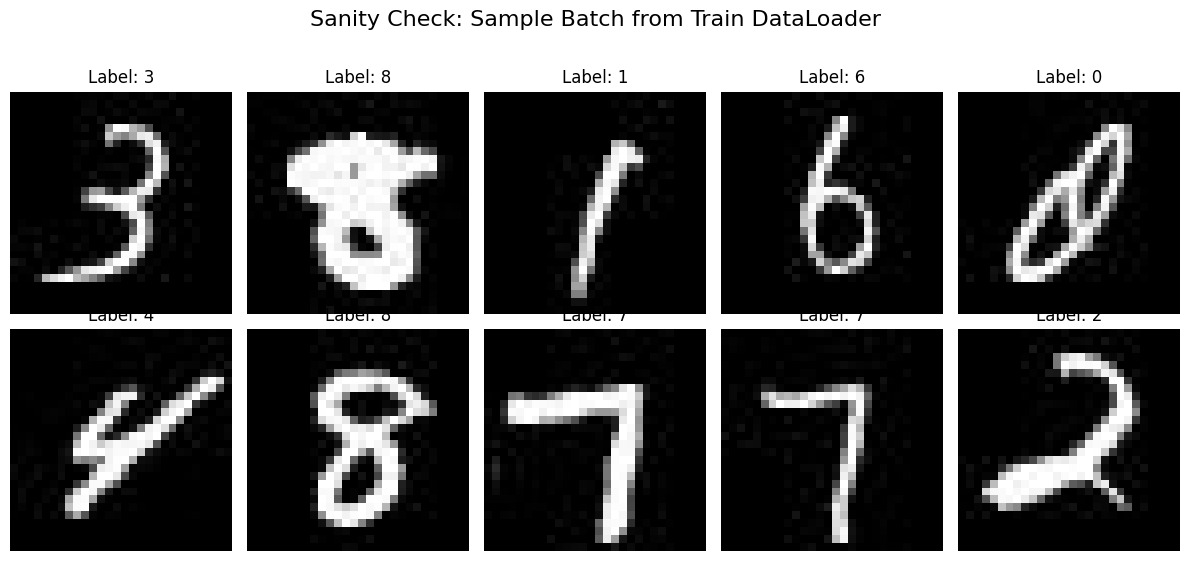

In [ ]:
# Implement your codes here!

import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

root_dir = "mnist_images"
batch_size = 64
num_workers = 2
pin_memory = True

class MNISTFolderDataset(Dataset):
    def __init__(self, root: str, split: str, transform=None):
        ##### YOUR CODE START #####

        self.root_dir = Path(root)
        self.split = split
        self.transform = transform

        self.split_dir = self.root_dir / self.split
        if not self.split_dir.is_dir():
            raise ValueError(f"Split directory not found: {self.split_dir}")

        self.samples = []

        for class_dir in sorted(self.split_dir.iterdir()):
            if not class_dir.is_dir():
                continue

            label = int(class_dir.name)

            for img_path in sorted(class_dir.glob("*.jpg")):
                self.samples.append((img_path, label))
        ##### YOUR CODE END #####

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ##### YOUR CODE START #####

        img_path, label = self.samples[idx]

        # 이미지를 그레이스케일('L') 모드로 열기
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, label
        ##### YOUR CODE END #####

transform = transforms.Compose([
    transforms.ToTensor(), # 이미지를 [0, 1] 범위의 텐서로 변환
    transforms.Normalize(mean=(0.5,), std=(0.5,)) # 픽셀 값을 [-1, 1] 범위로 정규화
])


train_ds = MNISTFolderDataset(root_dir, "train", transform=transform)
val_ds   = MNISTFolderDataset(root_dir, "val",   transform=transform)
test_ds  = MNISTFolderDataset(root_dir, "test",  transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_memory)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory)


# implement sanity check here
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")

images, labels = next(iter(train_loader))
print(f"\nBatch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

# recover the normalized images into the original space
def denorm(x):
    # x: tensor in [-1,1]
    return (x * 0.5) + 0.5  # -> [0,1]

# implement your code to visualize the actual samples using matplotlib using denorm function above

# 시각화
plt.figure(figsize=(12, 6))
plt.suptitle("Sanity Check: Sample Batch from Train DataLoader", fontsize=16)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = denorm(images[i]).squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Model Architecture

Design and implement a simple convolutional neural network for the MNIST dataset.
You are provided with a description of the architecture below, and your task is to implement the model class so that each layer’s output shape matches the description exactly.


**Model Description**

You may need to include appropriate activation functions in between.

0. input: (B, 1, 28, 28)
1. conv1: output (B, 32, 28, 28)
2. conv2: output (B, 64, 28, 28)
3. maxpool1: output (B, 64, 14, 14)
4. conv3: output (B, 128, 14, 14)
5. conv4: output (B, 128, 14, 14)
6. maxpool2: output (B, 128, 7, 7)
7. flatten: output (B, 128x7x7)
8. fc1: output (B, 256)
9. fc2: output (B, `n_class`)


**Requirements**
1. **Implement a model class** (`MyConvNet`).
- Use `nn.Conv2d`, `nn.ReLU`, `nn.MaxPool2d`, and `nn.Linear` layers.
- Adjust **`kernel_size` / `stride` / `padding`** so that each output shape matches the description above.
2. **Sanity check with zero input**  
- Create a zero tensor with shape **`[batch=10, channels=1, height=28, width=28]`** and run it through the model. Print the output shape.
3. Implementation Constraints
- Keep the architecture identical to the description.
- No BatchNorm or Dropout for this time.


In [ ]:
# Implement your codes here!

import torch
import torch.nn as nn

class MyConvNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        ##### YOUR CODE START #####

        # 학습 모델 모델링
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Classifier
        self.classifier = nn.Sequential(

            nn.Flatten(),
            nn.Linear(in_features=128 * 7 * 7, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=n_class)
        )
        ##### YOUR CODE END #####

    def forward(self, x):
        ##### YOUR CODE START #####
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x
        ##### YOUR CODE END #####

# define your model here & do the sanity check
n_class = 10
model = MyConvNet(n_class=n_class)
dummy_input = torch.zeros(10, 1, 28, 28)
output = model(dummy_input)
print(f"Model output shape for a dummy input: {output.shape}")

Model output shape for a dummy input: torch.Size([10, 10])


## Training with GPUs

**Goal**

Train your `MyConvNet` using **SGD** with **momentum** and **weight decay**. For here, do not use `test` set yet.

**Requirements**

0. Use GPUs!
1. **Optimizer**: `torch.optim.SGD`  
- **Momentum**: must be used (non-zero)  
- **Weight Decay**: must be used (non-zero)
2. **Loss**: `nn.CrossEntropyLoss()`
3. **Logging**:
- Define `history` dictionary with the keys of "train_loss" and "val_acc".
- **Store**: `train_loss` (epoch-average) and `val_acc` (epoch) into lists for later plotting
4. **Early Stopping**:  
- Keep track of best `val_acc`  
- When `val_acc` improves against the historical best, **save** model weights to `best.pth`  
- If no improvement for `patience` epochs, **stop**
5. Once your training is done, you should have:
- Plot two figures, each of `history["train_loss"]` and `history["val_acc"]` with epochs.
- Saved `best.pth` containing the best-performing weights on validation

Using device: cuda


Epoch 1 [Val]: 100%|██████████| 98/98 [00:02<00:00, 44.36it/s]


Epoch 1/20 - Train Loss: 0.3624, Val Acc: 97.32%
  -> New best model saved with accuracy: 97.32%


Epoch 2 [Val]: 100%|██████████| 98/98 [00:02<00:00, 33.42it/s]


Epoch 2/20 - Train Loss: 0.0513, Val Acc: 98.63%
  -> New best model saved with accuracy: 98.63%


Epoch 3 [Val]: 100%|██████████| 98/98 [00:02<00:00, 46.79it/s]


Epoch 3/20 - Train Loss: 0.0334, Val Acc: 98.70%
  -> New best model saved with accuracy: 98.70%


Epoch 4 [Val]: 100%|██████████| 98/98 [00:02<00:00, 45.83it/s]


Epoch 4/20 - Train Loss: 0.0249, Val Acc: 99.08%
  -> New best model saved with accuracy: 99.08%


Epoch 5 [Val]: 100%|██████████| 98/98 [00:02<00:00, 46.91it/s]


Epoch 5/20 - Train Loss: 0.0189, Val Acc: 98.86%
  -> No improvement. Patience: 1/3


Epoch 6 [Val]: 100%|██████████| 98/98 [00:02<00:00, 32.96it/s]


Epoch 6/20 - Train Loss: 0.0142, Val Acc: 99.08%
  -> No improvement. Patience: 2/3


Epoch 7 [Val]: 100%|██████████| 98/98 [00:02<00:00, 39.79it/s]


Epoch 7/20 - Train Loss: 0.0112, Val Acc: 98.96%
  -> No improvement. Patience: 3/3
Early stopping triggered after 3 epochs of no improvement.


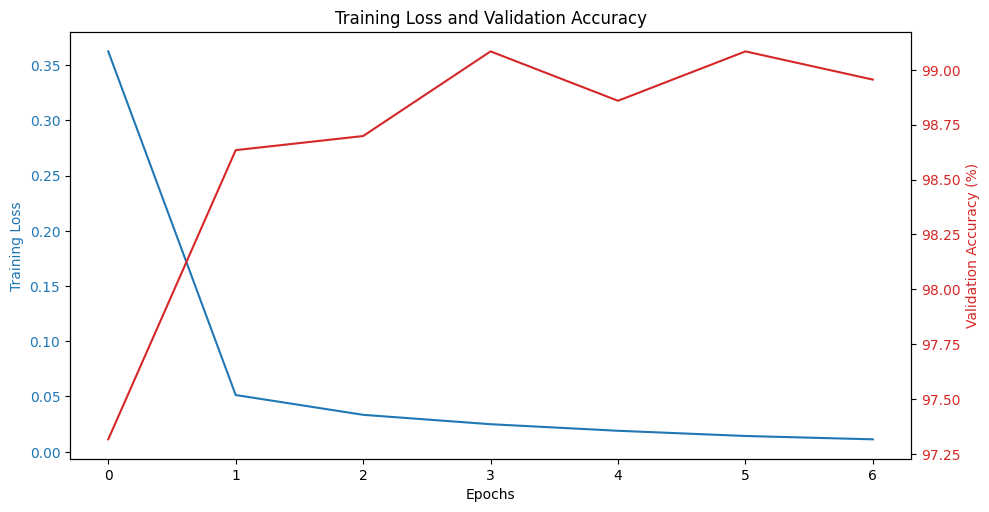

In [ ]:
# Implement your codes here!

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pathlib import Path

device = "cuda"
print("Using device:", device)

# define your hyper-parameters
max_epochs = 20
learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-4
patience = 3  # 조기 종료 임계값 3으로 지정


# define your model, loss, and optimizer
model = MyConvNet(n_class=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)


# define history for logging
history = {
    "train_loss": [],
    "val_acc": [],
}
best_val_acc = 0.0
patience_counter = 0


# 학습
for epoch in range(1, max_epochs + 1):

    # Training
    model.train()
    train_loss_sum = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

    avg_train_loss = train_loss_sum / len(train_loader)
    history["train_loss"].append(avg_train_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}/{max_epochs} - Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # 조기 종료
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best.pth")
        print(f"  -> New best model saved with accuracy: {best_val_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"  -> No improvement. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print(f"Early stopping triggered after {patience} epochs of no improvement.")
        break



# plot training loss and validation accuracy by epochs

# 결과 시각화
fig, ax1 = plt.subplots(figsize=(10, 5))

# 훈련 손실 그래프
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='tab:blue')
ax1.plot(history['train_loss'], color='tab:blue', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 검증 정확도 그래프 (Y축 공유)
ax2 = ax1.twinx()
ax2.set_ylabel('Validation Accuracy (%)', color='tab:red')
ax2.plot(history['val_acc'], color='tab:red', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Training Loss and Validation Accuracy')
plt.show()


## Evaluation with Test Set

**Objective**

Load the best-performing model checkpoint (`best.pth`) saved during training above and evaluate it on the **test dataset** to measure the final **test accuracy**. For here, no retraining allowed — this block only loads and evaluates.

Your model must achieve **at least 99% test accuracy** on MNIST.  
If your test accuracy is **below 99%**, you are required to **revisit and iterate on your training block** by adjusting hyperparameters (e.g., learning rate, momentum, weight decay, batch size, or number of epochs) until the requirement is met.

**Requirements**

1. Model Loading
- Recreate the same model architecture (`MyConvNet`) as used for training.
- Load the trained weights:
     ```python
     model.load_state_dict(torch.load("best.pth", map_location=device))
     ```
- Set the model to evaluation mode (`model.eval()`).

2. **Evaluation**
- Use your **test_loader** defined above, with the same preprocessing and normalization as during training.
- Wrap inference inside `torch.no_grad()` to disable gradients.
- Compute **overall test accuracy**

3. **Reporting**
- Print results clearly:
     ```
     Total test samples: <num>
     Correct predictions: <num>
     Test accuracy: <value>
     ```
- You must achieve **≥ 99%** accuracy.  
     If below, go back and **retrain** (adjust hyperparameters, increase epochs, etc.) until it meets the target.




In [ ]:
# 모델 로딩
eval_model = MyConvNet(n_class=10).to(device)
eval_model.load_state_dict(torch.load("best.pth", map_location=device))
eval_model.eval()

# 테스트
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        images, labels = images.to(device), labels.to(device)

        outputs = eval_model(images)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# 결과 보고
test_accuracy = 100 * test_correct / test_total

print("\n--- Final Test Result ---")
print(f"Total test samples: {test_total}")
print(f"Correct predictions: {test_correct}")
print(f"Test Accuracy: {test_accuracy:.4f}%")

if test_accuracy >= 99.0:
    print("\nCongratulations! Your model meets the required accuracy of >= 99%.")
else:
    print(f"\nYour model's accuracy ({test_accuracy:.4f}%) is below the 99% requirement.")
    print("Please go back to the training section, adjust hyperparameters, and retrain the model.")

Evaluating on Test Set: 100%|██████████| 157/157 [00:03<00:00, 39.78it/s]


--- Final Test Result ---
Total test samples: 10000
Correct predictions: 9905
Test Accuracy: 99.0500%

Congratulations! Your model meets the required accuracy of >= 99%.


## Submission

When you are ready to submit your materials:
1. Download best.pth to your local computer
2. Download your COSE-474-02-Assignment_1.ipynb file (make sure **all outputs are kept**) to your local computer
3. Create a zip file (e.g., 2025000000_jungbeomlee.zip), containing `best.pth` and `COSE-474-02-Assignment_1.ipynb` (DO NOT include mnist_images folder, it's too large!)


